# Image Dataset
----

Collection of `torch.utils.data.Dataset` classes for images

In [4]:
from torch.utils.data import Dataset
import os
import glob
import re
from PIL import Image
import numpy as np
from torchvision import transforms
import torch

In [16]:
class ImageMaskDataset(Dataset):
    
    def __init__(self, size):
        super(ImageMaskDataset, self).__init__()
        self.image_size = size
        self.file_list = []  # must be list of paired (image_filename, mask_filename)
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        # read both image and mask
        img = Image.open(self.file_list[idx][0])
        mask = Image.open(self.file_list[idx][1])
        
        # pad to get square size then resize to size
        max_size = np.array(img.size).max()
        pad_size = tuple((max_size - img.size) // 2)
        
        T = transforms.Compose([
            transforms.Pad(pad_size),
            transforms.Resize(self.image_size),
            transforms.ToTensor()
        ])
        
        # convert to tensor
        img = T(img)
        mask = T(mask)

        assert img.size()[1:] == mask.size()[1:], "Input & mask image sizes do not match"
        
        # stretch mask
        mask /= mask.max()
        
        # convert mask into 2 channels
        mask = mask.repeat(2,1,1)
        mask[0,:,:] = mask[0,:,:]>0.5
        mask[1,:,:] = mask[1,:,:]<=0.5
        
        # learning is faster if image is normalized to [-1.0, 1.0]
        img = (2.0 * transforms.Normalize([0.0]*3, [1.0]*3)(img)) - 1.0
                
        return img, mask
    
    @classmethod
    def from_folder(cls, image_folder, image_pattern, mask_fname_fun, **kwargs):
        """
        Image files are collected by os.path.join(image_folder, image_pattern)
        Corresponding mask file is retrieved by mask_fname_fun(os.path.basename(fname))
        
        E.g., if image files are fname.jpg and mask files are fname_mask.gif, then:
          mask_fname_fun = lambda f: f.replace('.jpg','_mask.gif')
        """
        
        # create object
        obj = cls(**kwargs)
        
        # read files
        image_files = glob.glob(os.path.join(image_folder, image_pattern))
        
        # build file_list
        obj.file_list = [
            (f, mask_fname_fun(os.path.basename(f))) for f in image_files
        ]
        return obj

### Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input image: torch.Size([3, 572, 572])
Mask image: torch.Size([2, 572, 572])


Text(0.5, 1.0, 'Mask background')

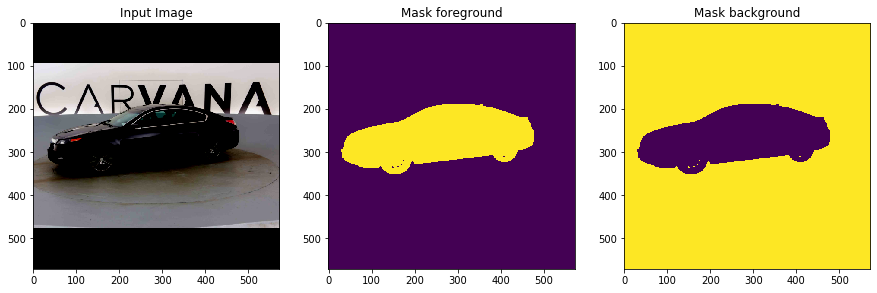

In [23]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# ds = ImageMaskDataset.from_folder(
#     size=(572, 572),
#     image_folder=r'/tmp/carvana/train/',
#     image_pattern='*.jpg',
#     mask_fname_fun=lambda f: os.path.join('/tmp/carvana/train_masks',
#                                           os.path.basename(f).replace('.jpg', '_mask.gif'))
# )
# img, mask = ds[np.random.choice(range(len(ds)))]
# print(f'Input image: {img.size()}')
# print(f'Mask image: {mask.size()}')

# _, axes = plt.subplots(1,3,figsize=(15,5))
# axes[0].imshow(img.permute(1,2,0).numpy())
# axes[0].set_title('Input Image')
# axes[1].imshow(mask[0,:,:].squeeze().numpy())
# axes[1].set_title('Mask foreground')
# axes[2].imshow(mask[1,:,:].squeeze().numpy())
# axes[2].set_title('Mask background')